In [1]:
# Import modules

import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


In [3]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'

In [4]:
try:
    goog_data2 = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    goog_data2 = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data2.to_pickle(SRC_DATA_FILENAME)

In [5]:
goog_data=goog_data2.tail(620)
lows=goog_data['Low']
highs=goog_data['High']

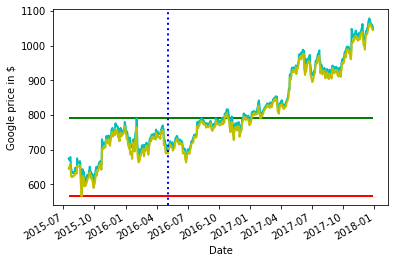

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
highs.plot(ax=ax1, color='c', lw=2.)
lows.plot(ax=ax1, color='y', lw=2.)
plt.hlines(highs.head(200).max(),lows.index.values[0],lows.index.values[-1],linewidth=2, color='g')
plt.hlines(lows.head(200).min(),lows.index.values[0],lows.index.values[-1],linewidth=2, color='r')
plt.axvline(linewidth=2,color='b',x=lows.index.values[200],linestyle=':')
plt.show()

In this code, the following applies:

1. This retrieves the financial data from the Yahoo finance website between January 1, 2014 and January 1, 2018.
2. We used the maximum and minimum values to create the support and the resistance limits

In this plot, the following applies:
1. We draw the highs and lows of the GOOG price.
2. The green line represents the resistance level, and the red line represents thesupport level.
3. To build these lines, we use the maximum value of the GOOG price and the minimum value of the GOOG price stored daily.
4. After the 200th day (dotted vertical blue line), we will buy when we reach thesupport line, and sell when we reach the resistance line. In this example, we used 200 days so that we have sufficient data points to get an estimate of the trend.
5. It is observed that the GOOG price will reach the resistance line around August 2016. This means that we have a signal to enter a short position (sell). 
6. Once traded, we will wait to get out of this short position when the GOOG price will reach the support line.
7. With this historical data, it is easily noticeable that this condition will not happen.
8. This will result in carrying a short position in a rising market without having any signal to sell it, thereby resulting in a huge loss
9. This means that, even if the trading idea based on support/resistance has strong grounds in terms of economical behavior, in reality, we will need to modify this trading strategy to make it work.
10. Moving the support/resistance line to adapt to the market evolution will be key to the trading strategy efficiency

If we take a new 200-day window after the first one, the support/resistance levels will be recalculated. We observe that the trading strategy will not get rid of the GOOG position (while the market keeps raising) since the price does not go back to the support level.

Since the algorithm cannot get rid of a position, we will need to add more parameters to change the behavior in order to enter a position. The following parameters can be added to the algorithm to change its position:
1. There can be a shorter rolling window.
2. We can count the number of times the price reaches a support or resistance line.
3. A tolerance margin can be added to consider that a support or resistance value can attain around a certain percentage of this value.

We can introduce two further parameters to the code:
1. The minimum number of times that a price needs to reach the support/resistance level.
2. We will define the tolerance margin of what we consider being close to the support/resistance level.

In [26]:
goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']
goog_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-17,674.468018,645.000000,649.000000,672.929993,11164900.0,672.929993
2015-07-20,668.880005,653.010010,659.239990,663.020020,5860900.0,663.020020
2015-07-21,673.000000,654.299988,655.210022,662.299988,3377200.0,662.299988
2015-07-22,678.640015,659.000000,660.890015,662.099976,3929300.0,662.099976
2015-07-23,663.630005,641.000000,661.270020,644.280029,3029100.0,644.280029


In [81]:
def trading_support_resistance(data,bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data))) # Tolerance Value for support
    data['res_tolerance'] = pd.Series(np.zeros(len(data))) # Tolerance Value for resistance
    data['sup_count'] = pd.Series(np.zeros(len(data))) # No of days where the price is in support
    data['res_count'] = pd.Series(np.zeros(len(data))) # No of days where the price is in resistance
    data['sup'] = pd.Series(np.zeros(len(data))) # Value for support
    data['res'] = pd.Series(np.zeros(len(data))) # Value for resistance 
    data['positions'] = pd.Series(np.zeros(len(data))) # Positions of our holdings: 1 -> Long(Buy) and -1 -> Short(Sell)
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support = 0
    in_resistance = 0
    bought = False
    
    for x in range((bin_width-1) + bin_width, len(data)): # Rolling Window
        data_section = data[x - bin_width:x+1] # Getting the data for the specific window
        support_level = min(data_section['price']) # Support level will be the minimum point in the window
        resistance_level = max(data_section['price']) # Resistance level will be the minimum point in the window
        range_level = resistance_level - support_level # Range level will be used to calculate the tolerance
        data['res'][x] = resistance_level # All the values will be appended to the last row of the window
        data['sup'][x] = support_level
        data['sup_tolerance'][x] = support_level + 0.2 * range_level # Tolerance Level of Support will be +20% of support value
        data['res_tolerance'][x] = resistance_level - 0.2 * range_level # Tolerance Level of Resistance  will be -20% of resistance value
        
        # If the current price of the stock (x will always point to the last row, thus current) falls between the resistance tolerance and reistance it will be a sinal to sell
        if data['price'][x] >= data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance += 1 # Tracks for how many consecutive days the price is between the resitance level and resistance tolerance
            data['res_count'][x] = in_resistance
            
        # If the current price of the stock (x will always point to the last row, thus current) falls between the support tolerance level and support level it will be a sinal to sell
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1 # Tracks for how many consecutive days the price is between the support tolerance and support level
            data['sup_count'][x] = in_support
        else: # When the stock is in range_level zone, that is, it is above support tolerance and below resistance tolerance
            in_support = 0
            in_resistance = 0

        if in_resistance > 2: # when the price stays in resistance for more than 2 datapoints then the signal is for sell
            data['signal'][x] = -1
        elif in_support >2: # when the price stays in support for more than 2 datapoints then the signal is for buy
            data['signal'][x] = 1
        else: # this will be when the price is in range_level zone
            data['signal'][x] = data['signal'][x-1]
        if data['signal'][x] != data['signal'][x-1]:
            if data['signal'][x] == -1 and bought == True:
                data['positions'][x] = data['signal'][x]
                bought = False
            elif data['signal'][x] == 1 and bought == False:
                data['positions'][x] = data['signal'][x]
                bought = True


In [82]:
trading_support_resistance(goog_data_signal)

In [83]:
goog_data_signal.tail()

,price,sup_tolerance,res_tolerance,sup_count,res_count,sup,res,positions,signal
Date,,,,,,,,,
2017-12-22,1060.119995,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,NaN,-1.0
2017-12-26,1056.739990,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,NaN,-1.0
2017-12-27,1049.369995,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,NaN,-1.0
2017-12-28,1048.140015,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,NaN,-1.0
2017-12-29,1046.400024,1014.371997,1061.44801,NaN,NaN,998.679993,1077.140015,NaN,-1.0


## Visualising

In [84]:
import matplotlib.pyplot as plt

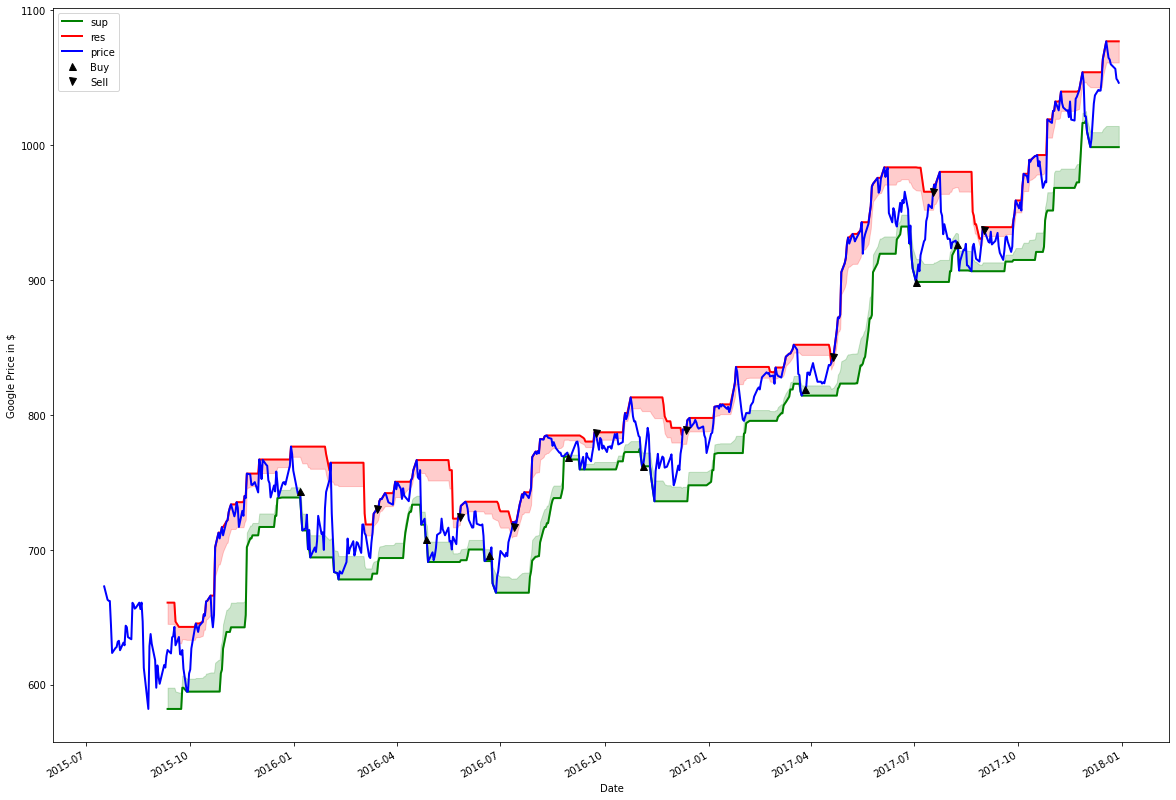

In [99]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(111,ylabel='Google Price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g',lw=2)
goog_data_signal['res'].plot(ax=ax1, color='r',lw=2)
goog_data_signal['price'].plot(ax=ax1, color='b',lw=2)
ax1.fill_between(
    goog_data_signal.index,
    goog_data_signal.sup_tolerance,
    goog_data_signal.sup,
    color='g',
    alpha=0.2
)
ax1.fill_between(
    goog_data_signal.index,
    goog_data_signal.res_tolerance,
    goog_data_signal.res,
    color='r',
    alpha=0.2
)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1].index,goog_data_signal.price[goog_data_signal.positions == 1], '^',markersize=7,color='k',label='Buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1].index,goog_data_signal.price[goog_data_signal.positions == -1], 'v',markersize=7,color='k',label='Sell')
plt.legend()
plt.show()
fig.savefig('support-and-resistance')